In [1]:
import numpy as np
from scipy import signal
import os
import string
import librosa
import time
import soundfile as sf
from threading import Thread

import gpuRIR

from multiprocessing import Process
import IPython.display as ipd

import matplotlib.pyplot as plt
%matplotlib inline

import soundfile as sf
from beamformers.beamformers import stft, condition_covariance

In [2]:
sr = 8000
# sample room size and spk/noise position
room = np.array([5, 6, 3])
length, width, height = room

source_pos_1 = np.array([[np.random.uniform(0.5,length-0.5),
               np.random.uniform(0.5,width-0.5),
               np.random.uniform(0.5,height-0.5)]])

source_pos_2 = source_pos_1 + np.array([[.5, .5, 0]])

# sample microphone center
# ad hoc array of 6 mics
mic_pos = []
for j in range(6):
    mic_center = np.asarray([np.random.uniform(0.5,length-0.5),
                           np.random.uniform(0.5,width-0.5),
                           np.random.uniform(0.5,height-0.5)])
    mic_pos.append(mic_center)

mic_pos = np.asarray(mic_pos)

# sample RT60
rt = np.random.uniform(0.1, 0.6)

# sample rir        
# echoic
beta = gpuRIR.beta_SabineEstimation(room, rt)
nb_img = gpuRIR.t2n(rt, room)

rir_1 = gpuRIR.simulateRIR(room, beta, source_pos_1, mic_pos, nb_img, rt, sr).squeeze()
rir_2 = gpuRIR.simulateRIR(room, beta, source_pos_2, mic_pos, nb_img, rt, sr).squeeze()

(6, 1846)
(6, 1846)
(6, 54759)
(6, 77518)


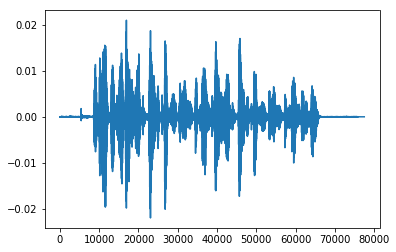

In [3]:
wave = '/Data/DATASETS/WSJ/tr_whole/40n/40na010x.wav'
s, _ = librosa.load(wave, sr=sr)
print(rir_1.shape)
print(rir_2.shape)

signal_1 = []
signal_2 = []

for mic in range(6):
    _s1 = signal.fftconvolve(s, rir_1[mic])
    signal_1.append(_s1)
    _s2 = signal.fftconvolve(s, rir_2[mic])
    signal_2.append(_s2)

signal_1 = np.array(signal_1)
signal_2 = np.array(signal_2)
print(signal_1.shape)
full_signal = np.hstack([signal_1[:, :-16000], signal_2[:, 16000:]])
# full_signal = np.hstack([signal_1, signal_2])

print(full_signal.shape)

plt.plot(full_signal[0])
ipd.display(ipd.Audio(full_signal[0], rate=sr))

In [48]:
full_signal, fs = sf.read('/Data/Dropbox/random_audio_samples/example_moving_source7.wav') 
print(full_signal.shape)
print(full_signal.shape[0] // fs)

(1508994, 6)
31


In [49]:
y_stft = stft(full_signal.T)
C, F, T = y_stft.shape
print(y_stft.shape)
cov = np.einsum('atc,btc->tcab', y_stft, np.conj(y_stft)) / T  # (freq_bins, channels, channels)
cov = condition_covariance(cov, 1e-6)
cov /= np.trace(cov, axis1=-2, axis2=-1)[..., None, None] + 1e-15

print(cov.shape)

(6, 1025, 2949)
(1025, 2949, 6, 6)


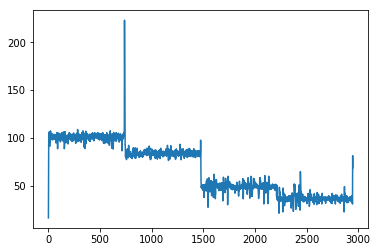

In [51]:
plt.plot(np.sum(np.abs(cov), 0)[:, 1, 5])

(2949,)


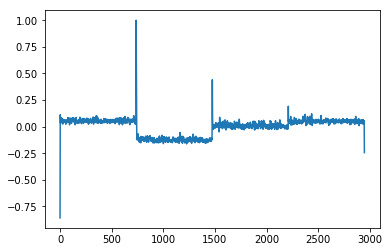

In [52]:
error = np.mean((np.abs(np.diff(cov, 1))) ** 2, axis=(0, 2, 3))
print(error.shape)
error -= np.mean(error)
error /= np.abs(np.max(error))
# power = np.sum(np.log10(np.abs(y_stft[0])), 0)
# power -= np.mean(power)
# power /= np.max(np.abs(power))
plt.plot(error)
# plt.plot(power)